In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import torch
import torch.nn as N
import torch.nn.functional as f
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
import torch.optim as op
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
(xtrain,ytrain),(xtest,ytest)=cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
xtrain.shape

(50000, 32, 32, 3)

In [4]:
ytrain_onehot=to_categorical(ytrain,10)
ytest_onehot=to_categorical(ytest,10)

In [5]:
class cifarmodel(N.Module):
    def __init__(self):
        super().__init__()
        self.q1=N.Conv2d(3,4,3,padding=1)
        self.k1=N.Conv2d(3,4,3,padding=1)
        self.v1=N.Conv2d(3,16,3,padding=1)
        self.p1=N.Conv2d(3,16,3,padding=1)
        self.maxp1=N.MaxPool2d(2,2)
        self.avg1=N.AvgPool2d(2,2)    #Adaptive Avgpool is like Global Average pooling
        self.b1=N.BatchNorm2d(16)
        
        self.q2=N.Conv2d(32,4,3,padding=1)
        self.k2=N.Conv2d(32,4,3,padding=1)
        self.v2=N.Conv2d(32,32,3,padding=1)
        self.p2=N.Conv2d(32,32,3,padding=1)
        self.maxp2=N.MaxPool2d(2,2)
        self.avg2=N.AvgPool2d(2,2)
        self.b2=N.BatchNorm2d(32)
        
        self.q3=N.Conv2d(64,4,3,padding=1)
        self.k3=N.Conv2d(64,4,3,padding=1)
        self.v3=N.Conv2d(64,64,3,padding=1)
        self.p3=N.Conv2d(64,64,3,padding=1)
        self.maxp3=N.MaxPool2d(2,2)
        self.avg3=N.AvgPool2d(2,2)
        self.b3=N.BatchNorm2d(64)
        self.fc1=N.Linear(2048,10)
        
    def attention(self,q,k,v,p,b,x):
            
        # x bs x h x w x c 
        # x has to be fed into layer in shape of bs x c x h x w
        h=x.shape[1]
        w=x.shape[2]
        bs=x.shape[0]
        x1=x
        x=x.permute(0,3,1,2)

        qv=q(x)     
        kv=k(x)
        vv=v(x)
        pv=p(x)
        C2=vv.shape[1]

        qv=qv.permute(0,2,3,1)
        kv=kv.permute(0,2,3,1)
        #print(vv.shape)
        vv=vv.permute(0,2,3,1)

        vf=torch.flatten(vv,1,2)
        qf= torch.flatten(qv,1,2)  # bs x hw x c1
        kf= torch.flatten(kv,1,2)  # bs x hw x c1

        attenscalar=torch.matmul(qf,kf.permute(0,2,1))  # bs x hw x hw
        attenprob = torch.nn.Softmax(dim=-1)(attenscalar) # bs x hw x hw
        #print(attenprob.shape)
        #print(vf.shape)

        nqv=torch.matmul(attenprob,vf)     # bs x hw x C2
        nqv=nqv.view(-1,h,w,C2)
        nqv=f.relu(nqv)
        #print(pv.shape)
        #print(nqv.shape)
        nqv=nqv+pv.permute(0,2,3,1)
        nqv=b(nqv.permute(0,3,1,2))
        
        return nqv.permute(0,2,3,1)
        
    def forward(self,x):
        #print("1")
        out=self.attention(self.q1,self.k1,self.v1,self.p1,self.b1,x)
        #print("2")
        #out=f.relu(out)
        max1=self.maxp1(out.permute(0,3,1,2))
        avg1=self.avg1(out.permute(0,3,1,2))
        cat1=torch.cat([max1,avg1],dim=1)
        out=cat1.permute(0,2,3,1)
        
        out1=self.attention(self.q2,self.k2,self.v2,self.p2,self.b2,out)
        #out1=f.relu(out1)
        max2=self.maxp2(out1.permute(0,3,1,2))
        avg2=self.avg2(out1.permute(0,3,1,2))
        cat2=torch.cat([max2,avg2],dim=1)
        out1=cat2.permute(0,2,3,1)

        out2=self.attention(self.q3,self.k3,self.v3,self.p3,self.b3,out1)
        #out2=f.relu(out2)
        max3=self.maxp3(out2.permute(0,3,1,2))
        avg3=self.avg3(out2.permute(0,3,1,2))
        cat3=torch.cat([max3,avg3],dim=1)
        out2=cat3.permute(0,2,3,1)
        out2=torch.flatten(out2,1,3)
        fc=self.fc1(out2)
        return fc
            

In [6]:
xtrain1=xtrain.astype(np.float32)/255


In [7]:
model1=cifarmodel()

In [8]:
model1

cifarmodel(
  (q1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (k1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (v1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (p1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (b1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (q2): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (k2): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (v2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (p2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (b2): BatchNorm2d(32, eps=1e-0

In [9]:
# total number of weights
sum([l.numel() for l in model1.parameters()])

121114

In [10]:
l1=list(model1.parameters())[0]

In [11]:
l1.numel()

108

In [12]:
img=torch.randint(0,10,size=(1,8,8,16)).float()
q1=N.Conv2d(16,4,3,padding=1)
k1=N.Conv2d(16,4,3,padding=1)
v1=N.Conv2d(16,16,3,padding=1)
p1=N.Conv2d(16,16,3,padding=1)

In [13]:
def attention(q,k,v,p,x):
            
    # x bs x h x w x c 
    # x has to be fed into layer in shape of bs x c x h x w
    h=x.shape[1]
    w=x.shape[2]
    bs=x.shape[0]
    x1=x
    x=x.permute(0,3,1,2)

    qv=f.relu(q(x))     
    kv=f.relu(k(x))
    vv=f.relu(v(x))
    pv=p(x)
    C2=vv.shape[1]

    qv=qv.permute(0,2,3,1)
    kv=kv.permute(0,2,3,1)
    #print(vv.shape)
    vv=vv.permute(0,2,3,1)

    vf=torch.flatten(vv,1,2)
    qf= torch.flatten(qv,1,2)  # bs x hw x c1
    kf= torch.flatten(kv,1,2)  # bs x hw x c1

    attenscalar=torch.matmul(qf,kf.permute(0,2,1))  # bs x hw x hw
    attenprob = torch.nn.Softmax(dim=-1)(attenscalar) # bs x hw x hw
    #print(attenprob.shape)
    #print(vf.shape)

    nqv=torch.matmul(attenprob,vf)     # bs x hw x C2
    nqv=nqv.view(-1,h,w,C2)
    #print(pv.shape)
    #print(nqv.shape)
    nqv=nqv+pv.permute(0,2,3,1)

    nqv=f.relu(nqv)

    return nqv

In [14]:
batchx=torch.randn(4,32,32,3)

In [15]:
batchx.shape

torch.Size([4, 32, 32, 3])

In [16]:
model1.forward(batchx).shape

torch.Size([4, 10])

In [17]:
max3=N.MaxPool2d(2,2)
avg3=N.AvgPool2d(2,2)

In [18]:
bm1=max3(batchx.permute(0,3,1,2))

In [19]:
avgm1=avg3(batchx.permute(0,3,1,2))

In [20]:
avgm1.shape

torch.Size([4, 3, 16, 16])

In [21]:
concat=torch.cat([bm1,avgm1],dim=1)

In [22]:
concat.shape

torch.Size([4, 6, 16, 16])

In [23]:
len(list(model1.parameters()))

32

In [24]:
sum([l.numel() for l in model1.parameters()])

121114

In [25]:
optim1=op.Adam(model1.parameters(),lr=0.001)

In [26]:
loss=N.CrossEntropyLoss()

In [27]:
nepochs=10
batchsize=32


In [28]:
device1=torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [29]:
model1=model1.to(device1)
loss1=loss.to(device1)

In [30]:
device1

device(type='cuda')

In [31]:
trainloss=[]
count=0
n=len(xtrain)
m=n//batchsize
for i in range(nepochs):
    for j in range(m):
        
        batchx=torch.from_numpy(xtrain1[j*batchsize:(j+1)*batchsize])
        batchy=torch.from_numpy(ytrain[j*batchsize:(j+1)*batchsize]).long()
        optim1.zero_grad()
        batchx=batchx.to(device1)
        batchy=batchy.to(device1)
        
        output=model1.forward(batchx)
        
        # print(output.shape)
        # print(batchy.shape)
        l=loss1(output,batchy.reshape(-1,))
        l.backward()
        optim1.step()
        count+=1
        trainloss.append(l.detach().cpu().numpy())
        if count%100==0:
            print("loss is :-",l.detach().cpu().numpy()," and count is:-",count)
        

loss is :- 1.6272584  and count is:- 100
loss is :- 1.5400829  and count is:- 200
loss is :- 1.1788496  and count is:- 300
loss is :- 1.58504  and count is:- 400
loss is :- 1.7441494  and count is:- 500
loss is :- 1.2607884  and count is:- 600
loss is :- 1.5828398  and count is:- 700
loss is :- 1.1991591  and count is:- 800
loss is :- 1.4685826  and count is:- 900
loss is :- 1.0634173  and count is:- 1000
loss is :- 1.3256643  and count is:- 1100
loss is :- 1.2528012  and count is:- 1200
loss is :- 1.4224787  and count is:- 1300
loss is :- 1.2087339  and count is:- 1400
loss is :- 0.932765  and count is:- 1500
loss is :- 0.87594  and count is:- 1600
loss is :- 0.6991373  and count is:- 1700
loss is :- 1.1072857  and count is:- 1800
loss is :- 1.2854531  and count is:- 1900
loss is :- 1.0832498  and count is:- 2000
loss is :- 0.8555817  and count is:- 2100
loss is :- 1.0035678  and count is:- 2200
loss is :- 1.2132678  and count is:- 2300
loss is :- 0.8103312  and count is:- 2400
loss i

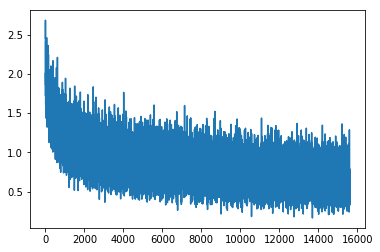

In [32]:
#detach() will remove loss from graph 
#cpu() will move tensor to cpu
plt.plot(trainloss)